In [184]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

violations = pd.read_csv('violations.csv', header=0, parse_dates=True)
violations = data.dropna(subset=['Latitude','Longitude'])

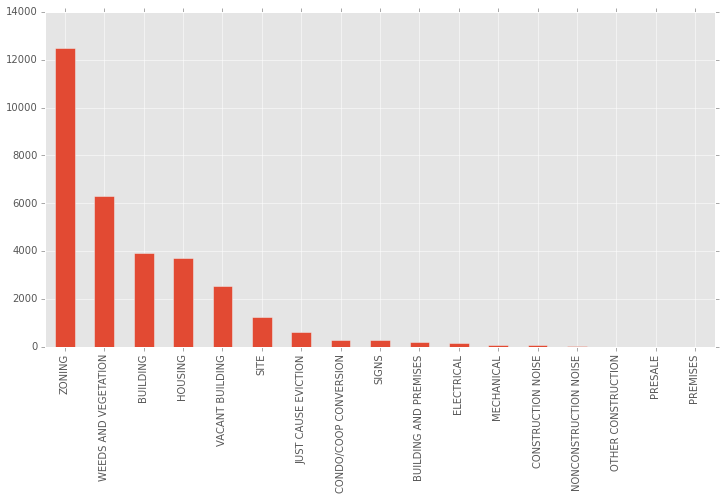

In [185]:
violations['Case Group'].value_counts().plot(kind='bar', figsize=(12,6))

In [186]:
violations['Case Group'].value_counts()

ZONING                   12476
WEEDS AND VEGETATION      6291
BUILDING                  3905
HOUSING                   3699
VACANT BUILDING           2522
SITE                      1265
JUST CAUSE EVICTION        608
CONDO/COOP CONVERSION      305
SIGNS                      301
BUILDING AND PREMISES      212
ELECTRICAL                 176
MECHANICAL                  92
CONSTRUCTION NOISE          84
NONCONSTRUCTION NOISE       54
OTHER CONSTRUCTION          11
PRESALE                      8
PREMISES                     4
dtype: int64

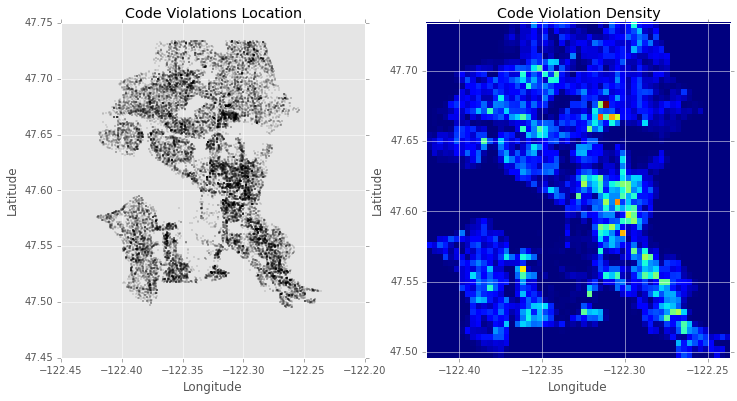

In [187]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

violations.plot(kind='scatter', x='Longitude', y='Latitude', ax=axes[0], s=0.5, c='k',
          linewidths=0).set_title('Code Violations Location') 
axes[1].hist2d(violations['Longitude'],violations['Latitude'], bins=55)

axes[0].get_xaxis().get_major_formatter().set_useOffset(False) 
axes[1].get_xaxis().get_major_formatter().set_useOffset(False)
axes[1].set_title('Code Violation Density') 
axes[1].set_xlabel('Longitude') 
axes[1].set_ylabel('Latitude')

In [188]:
case_counts = violations['Date Case Created'].value_counts()
inspec_counts = violations['Last Inspection Date'].value_counts()
total_counts = inspec_counts.add(case_counts, fill_value=0)

case_dates = pd.to_datetime(case_counts.index, format='%m/%d/%Y')
inspec_dates = pd.to_datetime(inspec_counts.index, format='%m/%d/%Y')
total_dates = total_counts.index.to_datetime()

inspections = pd.DataFrame({'Case Creation': pd.Series(case_counts.tolist(), index=case_dates),
                           'Followup Inspection': pd.Series(inspec_counts.tolist(), index=inspec_dates),
                          'Total Inspections': pd.Series(total_counts.tolist(), index=total_dates)})

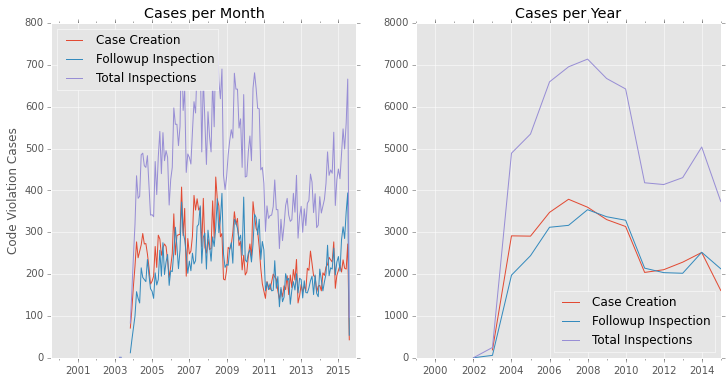

In [189]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
axes[0].set_ylabel('Code Violation Cases')
inspections.resample('M',how='sum').plot(ax=axes[0]).set_title('Cases per Month')
inspections.resample('A',how='sum').plot(ax=axes[1]).set_title('Cases per Year')

In [190]:
SEASON = {1:'Winter', 2:'Winter', 3:'Winter', 4:'Spring', 5:'Spring', 6:'Spring', 
          7:'Summer', 8:'Summer', 9:'Summer', 10:'Autumn', 11:'Autumn', 12:'Winter'}

case_seasons = pd.Series([SEASON[i] for i in case_dates.month])
all_seasons = pd.Series([SEASON[i] for i in pd.DatetimeIndex(violations['Date Case Created']).month])

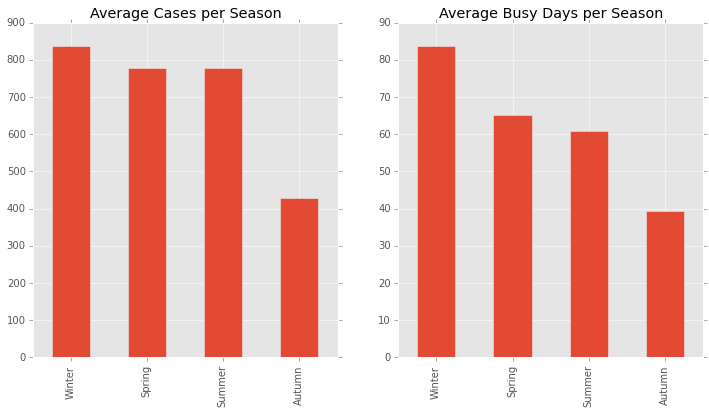

In [191]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
(all_seasons.value_counts() / 12.).plot(kind='bar', ax=axes[0])
(case_seasons.value_counts() / 12.).plot(kind='bar', ax=axes[1])
axes[1].set_title('Average Busy Days per Season')
axes[0].set_title('Average Cases per Season')

In [192]:
WEEKDAY = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 
            4:'Fri', 5:'Sat', 6:'Sun'}

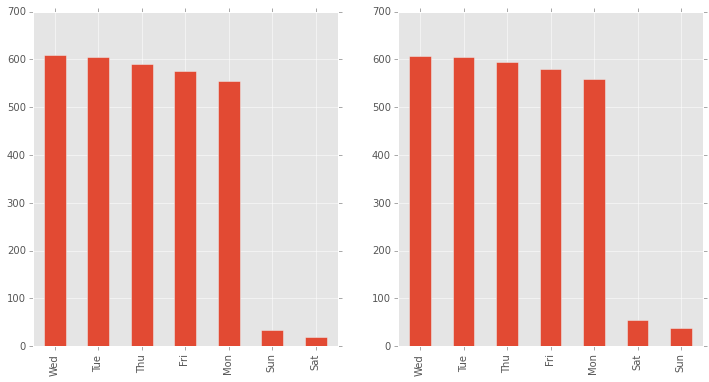

In [193]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
pd.Series([WEEKDAY[i] for i in case_dates.weekday]).value_counts().plot(kind='bar', ax=axes[0])
pd.Series([WEEKDAY[i] for i in inspec_dates.weekday]).value_counts().plot(kind='bar', ax=axes[1])

In [194]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    diff = date - pd.datetime(2000, 12, 21)
    day = diff.total_seconds() / 24. / 3600
    day %= 365.25
    m = 1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(day * np.pi / 182.625))
    m = max(0, min(m, 2))
    return 24. * np.degrees(np.arccos(1 - m)) / 180.

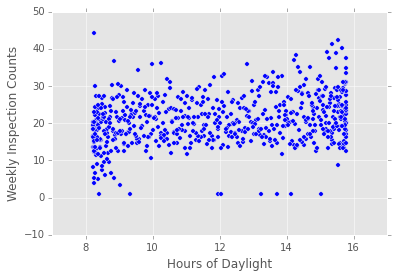

In [493]:
inspec_weekly = inspections['Total Inspections'].resample('W').dropna()
inspec_weekly = inspec_weekly[:,np.newaxis]
daylight_weekly = weekly.dropna().index.map(hours_of_daylight)
daylight_weekly = daylight_weekly[:,np.newaxis]

plt.scatter(daylight_weekly, inspec_weekly)
plt.xlabel('Hours of Daylight')
plt.ylabel('Weekly Inspection Counts')

In [494]:
from sklearn.linear_model import LinearRegression

fit = LinearRegression().fit(daylight_weekly, inspec_weekly)
weekly_fit = fit.predict(daylight_weekly)

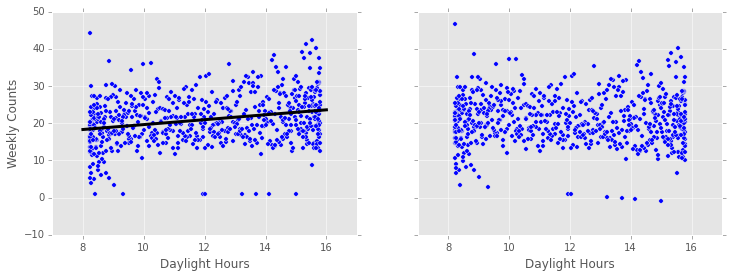

In [496]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4), sharey=True)
xspace = np.linspace(8,16)[:,np.newaxis]

axes[0].scatter(daylight_weekly, inspec_weekly)
axes[0].plot(xspace, fit.predict(xspace), 'k', linewidth=3)
axes[1].scatter(daylight_weekly, inspec_weekly - weekly_fit + np.mean(weekly_fit))

axes[0].set_xlabel('Daylight Hours') ; axes[0].set_ylabel('Weekly Counts')
axes[1].set_xlabel('Daylight Hours')

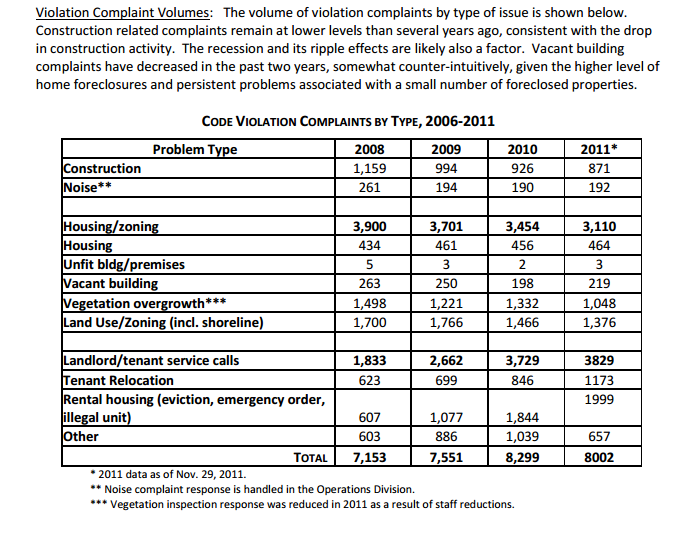

In [199]:
from IPython.display import Image
Image(filename='violations.png')

In [231]:
construction1 = pd.read_csv('construction.csv', header=0, parse_dates=True)
construction2 = pd.read_csv('construction2.csv', header=0, parse_dates=True)
construction = pd.concat([construction1,construction2])

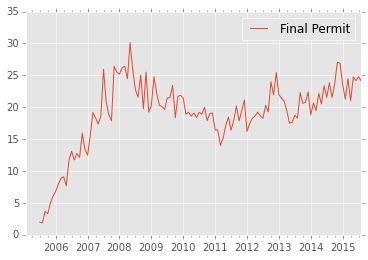

In [523]:
permit_counts = construction['Final Date'].value_counts()
permit_dates = pd.to_datetime(permit_counts.index, format='%m/%d/%Y')

permits = pd.DataFrame({'Final Permit': pd.Series(permit_counts.tolist(), index=permit_dates)})
permits.resample('M').plot()

In [533]:
data = inspections.join(permits).resample('W').fillna(0)
data = data.sort()
columns = ['Final Permit']

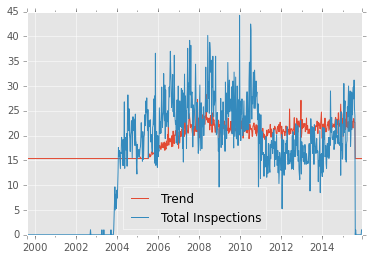

In [534]:
from sklearn.linear_model import LinearRegression
fit = LinearRegression().fit(data[columns]['2005-08-16':],data['Total Inspections']['2005-08-16':])
data['Trend'] = fit.predict(data[columns])
data[['Trend','Total Inspections']].plot()

In [535]:
fit.coef_

array([ 0.30735833])